# Automatización de reportes de payroll

Todas las empresas uruguayas deben remitir mensualmente la información de los salarios pagados al Banco de Previsión Social (BPS). Ésto se realiza a través de un formato y una codificación específica, y por lo general es cumplimentado por estudios tercerizados o un departamento especializado dentro de la empresa.

Nuestra intención con este desarrollo es lograr automatizar un reporting independiente de los estudios o de los departamentos especializados. Algunos aspectos que nos motivan son:
* Uniformidad: Ya que todas las declaraciones nominadas para industria y comercio comparten formato y codificación, este desarrollo puede ser aplicado en cualquiera de ellas independientemente de su estructura informática, el software utilizado o la calidad de sus archivos.
* Eficiencia: Los equipos de RH, payroll o similares suelen tener que compilar información y estructurarla a las necesidades de análisis de las gerencias, cuando no están especializados en ello.
* Control: Para los casos en los que ya se cuente con procedimientos de reporting, este proceso automático le puede devolver algunos datos sobre cuales controlar si las retribuciones al personal y contribuciones a la seguridad social se han realizado y registrado de forma correcta.

In [1]:
# Importamos los paquetes necesarios para nuestro desarrollo

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import io
from urllib.request import urlopen

Definimos la ruta de los archivos a importar y definimos una lista "nóminas" que contenga cada archivo. En este caso lo hacemos para un trimestre, pero puede ser para cualquier otra cantidad de meses.

In [2]:
n_enero = "https://raw.githubusercontent.com/GregorioMorena/BPS_Reporting/main/N_1_7301273_202001.txt"
n_febrero = "https://raw.githubusercontent.com/GregorioMorena/BPS_Reporting/main/N_1_7301273_202002.txt"
n_marzo = "https://raw.githubusercontent.com/GregorioMorena/BPS_Reporting/main/N_1_7301273_202003.txt"

nominas = [n_enero, n_febrero, n_marzo]


Los archivos del BPS cuentan con un formato preestablecido pero no puede ser importado directamente por Pandas sin un proceso previo dado que el archivo no cuenta con un número de separadores fijos para cada línea.
Lo modificaremos de forma tal de que sea legible para el módulo pandas. Para ello definiremos la función f_bps

In [3]:
# Modificar el archivo txt de atyro para insertar un encabezado que tenga la misma cantidad
# de separadores que el máximo encontrado en el resto de las filas
def f_bps(path, delimiter='|'):
    
    datos = ''
    max_cols = 0
    
    with urlopen(path) as file:
        for line in file:
            datos = (datos + line.decode("utf-8"))
            col_count = line.decode("utf-8").count(delimiter)
            if col_count > max_cols:
                max_cols = col_count
            
    
    encabezado = delimiter * max_cols + '\n'
    
    return io.StringIO(encabezado + datos)

Con la función definida, recorremos la lista de archivos para concatenar cada archivo en un único dataframe.

In [4]:
importacion = pd.DataFrame()
for i in nominas:    
    importacion = pd.concat([importacion, pd.read_csv(f_bps(i), delimiter='|')], ignore_index=True)

Y el resultado es el siguiente dataframe

In [5]:
importacion.head()

,Unnamed: 0,Unnamed: 1,Unnamed: 2,Unnamed: 3,Unnamed: 4,Unnamed: 5,Unnamed: 6,Unnamed: 7,Unnamed: 8,Unnamed: 9,Unnamed: 10,Unnamed: 11,Unnamed: 12,Unnamed: 13,Unnamed: 14,Unnamed: 15,Unnamed: 16,Unnamed: 17,Unnamed: 18,Unnamed: 19
0,1,N,3.1,Atyro 3.2.39,0000003721037,00214314640010,1,CONSTRUCTION SRL,MONTEVIDEO,0800 2001,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,4,012019,1,46993426,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,5,1,DO,2161a684,Lucero,Soto,Antonio,Alberto,27654,1,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,6,NaN,1,DO,2161a684,1,40179,1,48,12,9.0,99.0,NaN,NaN,N,30.0,0.0,1.0,NaN,NaN
4,7,NaN,1,DO,2161a684,1,1,78163.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


La información sigue sin ser legible, pero ahora podemos manipularlacon Pandas.
Gracias a que conocemos la forma en que se ordena y codifican los archivos de BPS, podemos analizar dónde está la información relevante a extraer.

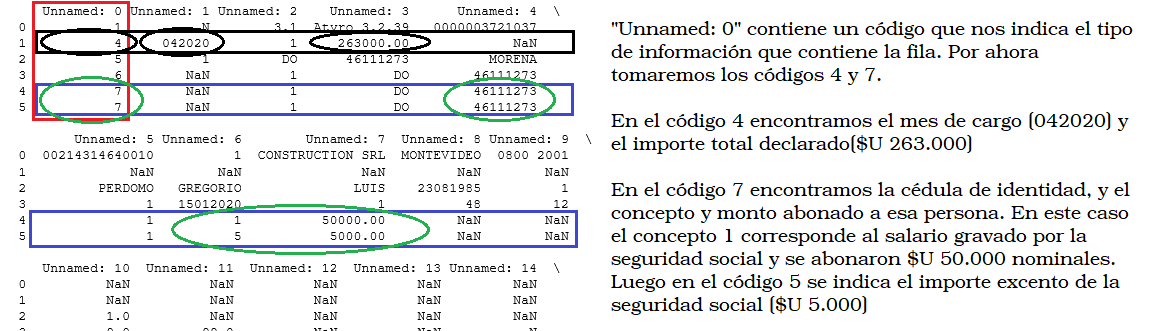

Definimos un dataframe vacío al cual le vamos a ir agregando sólamente las columnas relevantes de la información importada. La primer columna relevante es aquella que contiene el mes de cargo.

In [6]:
# DataFrame vacío
tabla_bruta= pd.DataFrame()

"""Creamos una lista donde indiquemos qué tipo de registro hay en cada fila"""
registro = importacion.iloc[:,0].tolist()

""" Para crear la fila que indique el mes de cargo, necesitamos extraer sólamente el segundo
dato de los registros con número 4 y continuar usando ese dato en las siguientes filas"""
mes = []

for num in range(len(registro)):
    if registro[num] == 4:
        mes = mes + [importacion.iloc[num,1]]
    else:
        mes = mes + [np.nan]

tabla_bruta['mes'] = mes
tabla_bruta['mes'] = tabla_bruta['mes'].fillna(method='ffill')

Continuamos extrayendo columnas con información relevante. El tipo de registro, el documento de identidad, el concepto abonado y el importe correspondiente a ese concepto. Por último, con algo más de dificultad, agregamos la cantidad de días trabajados (según el criterio de la seguridad social) para ese mes en concreto.

In [7]:
# Extracción de columnas con datos relevantes
tabla_bruta['tipo_registro'] = importacion.iloc[:,0]
tabla_bruta['documento'] = importacion.iloc[:,4]
tabla_bruta['concepto'] = importacion.iloc[:,6]
tabla_bruta['importe'] = importacion.iloc[:,7]

# Extracción de la columna que contiene los días trabajados para ese mes. 
tabla_bruta['dt'] = importacion.iloc[:,15]
tabla_bruta['dt'] = tabla_bruta['dt'].fillna(method='ffill')

for i in range(len(tabla_bruta['dt'])):
    try:
        tabla_bruta.iloc[i, 3] = int(tabla_bruta.iloc[i, 3])
        if tabla_bruta.iloc[i, 3] != 1:
            tabla_bruta.iloc[i, 5] = 0
    except:
        tabla_bruta.iloc[i,3] = 0



# Veamos las primeras líneas de nuestra tabla

tabla_bruta.head()

,mes,tipo_registro,documento,concepto,importe,dt
0,NaN,1,0000003721037,1,CONSTRUCTION SRL,NaN
1,012019,4,NaN,0,NaN,NaN
2,012019,5,Lucero,0,Alberto,NaN
3,012019,6,2161a684,40179,1,0.0
4,012019,7,2161a684,1,78163.00,30.0


Por la forma en la que armamos la tabla anterior, alcanza con filtrar todas las observaciones con "tipo_registro" 7.

In [8]:
# Creamos una tabla que sólo contenga los tipo_registro = 7
# y le damos un formato adecuado a los importes (importe) y a los días trabajados (dt)

tabla_final = tabla_bruta[tabla_bruta['tipo_registro'] == 7][['mes', 'documento', 'dt', 'concepto', 'importe']]
tabla_final = tabla_final.astype({'importe': float,
                                  'dt': int})

# Visualizamos las primeras lineas de nuestra tabla final
tabla_final.head()

,mes,documento,dt,concepto,importe
4,012019,2161a684,30,1,78163.0
7,012019,296b808,30,1,74161.0
10,012019,4436a142,30,1,60042.0
11,012019,4436a142,0,7,1950.0
14,012019,193e706,30,1,77617.0


A modo de verificación, tomamos la suma de los importes totales indicado en cada nómina original y lo comparamos con el total de nuestra tabla.

In [9]:
# Seleccionamos los importes totalizados de los archivos importados y los sumamos
suma_original = pd.to_numeric(importacion[importacion.iloc[:,0] == 4].iloc[:,3]).sum()

# Sumamos el total de retribuciones según nuestra tabla final
suma_final = tabla_final['importe'].sum()

# Verificamos si son iguales
verificacion = suma_original - suma_final

if verificacion == 0:
    result = 'La importación se realizó correctamente'
else:
    result = 'Error en la imporacion. Diferencia de $U' + str(verificacion)

result

'La importación se realizó correctamente'

# Un reporte rápido con la información importada

Una vez realizada la importación de los archivos y la limpieza de la información, podemos diseñar reportes de mayor o menor complejidad. A modo de ejemplo, chequearemos la cantidad de jornales y los importes pagados del primer trimestre.

In [10]:
informe = pd.pivot_table(tabla_final, values=['dt', 'importe'], index=['mes'], aggfunc=np.sum)
informe

,dt,importe
mes,,
012019,20678,46993426.0
022019,20359,47122667.0
032019,20700,57752267.0


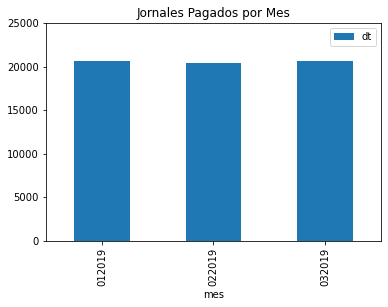

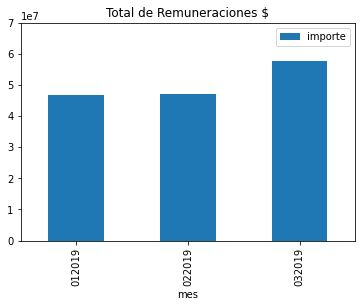

In [11]:
informe.plot(y='dt', kind='bar').set_title('Jornales Pagados por Mes')
plt.ylim([0,25000])
informe.plot(y='importe', kind='bar').set_title('Total de Remuneraciones $')
plt.ylim([0,70000000])
plt.show()

# Conclusiones

Hemos desarrollado una forma sencilla de automatizar un análisis de los costos del personal basados sólamente en la información contenida en la seguridad social uruguaya (BPS). Desde aquí podríamos extraer incluso más información como pueden ser vacaciones, rotación, impuestos, cargas sociales, etc.

Para agregar más valor a este desarrollo, se podría sugerir agregar información de otras fuentes como pueden ser:
* Planilla de Trabajo: Nos daría información sobre salario pactado de cada persona, el horario, los descansos y la forma de retribución.
* Convenios colectivos: En los convenios y sus sucesivas actas se detallan aumentos, partidas varias e información variada que podría resultar útil según el análisis deseado.
* Información ya existente en la empresa: Cualquier registro sobre el personal o cualquier otro aspecto que se quiera agregar a los reportes como por ejemplo: marcas de entrada y salida, rentabilidad por producto, cantidad de ventas por sucursal, etc.

¡Gracias por interesarte por mi proyecto! Ante cualquier duda, puedes contactarme:

https://www.linkedin.com/in/gregoriomorena/

https://twitter.com/GregorioMP1985
